In [ ]:
import os
import re
import pickle
import numpy as np
import unicodedata
import pandas as pd
import seaborn as sns
import networkx as nx
!pip install fa2_modified
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from fa2_modified import ForceAtlas2
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Load the graph from the pickle file
with open('flight_network_graph.pickle', 'rb') as f:
   G = pickle.load(f)

In [ ]:
df = pd.read_csv('worldcities2.csv')
print(df)

                   city        city_ascii      lat       lng  \
0                 Tokyo             Tokyo  35.6897  139.6922   
1               Jakarta           Jakarta  -6.1750  106.8275   
2                 Delhi             Delhi  28.6100   77.2300   
3             Guangzhou         Guangzhou  23.1300  113.2600   
4                Mumbai            Mumbai  19.0761   72.8775   
...                 ...               ...      ...       ...   
47863        Munha-dong        Munha-dong  39.3813  127.2517   
47864            Sil-li            Sil-li  39.4880  125.4640   
47865              Muan              Muan  34.9897  126.4714   
47866         Hongseong         Hongseong  36.6009  126.6650   
47867  Charlotte Amalie  Charlotte Amalie  18.3420  -64.9331   

                   country iso2 iso3      admin_name  capital  population  \
0                    Japan   JP  JPN           Tōkyō  primary  37732000.0   
1                Indonesia   ID  IDN         Jakarta  primary  33756000.0   


In [ ]:
# Function to normalize city names
def normalize_city_name(city_name):
    # Replace common abbreviations like 'St' with 'Saint'
    city_name = re.sub(r'\bSt\b', 'Saint', city_name, flags=re.IGNORECASE)

    # Remove hyphens and other non-alphanumeric characters
    city_name = re.sub(r'[^a-zA-Z0-9]', '', city_name)

    # Remove accents and convert to lowercase
    city_name = unicodedata.normalize('NFKD', city_name).encode('ASCII', 'ignore').decode('ASCII')

    # Convert to lowercase to ensure case-insensitivity
    city_name = city_name.lower()

    return city_name

# Function to add population as integers to the graph
def add_population_to_graph(graph, city_df):
    # Ensure the DataFrame has no missing values in the matching column
    city_df = city_df[~city_df['city_ascii'].isnull()]

    # Normalize the graph node names (ensure the city names in the graph are also standardized)
    normalized_nodes = {normalize_city_name(node): node for node in graph.nodes}

    # Iterate through the DataFrame
    for _, row in city_df.iterrows():
        city = row['city_ascii']
        population = row['population']

        # Normalize the city name
        normalized_city = normalize_city_name(city)

        # Convert population to integer if it is not null
        if not pd.isnull(population):
            population = int(population)

        # Check if the normalized city name exists in the graph nodes
        if normalized_city in normalized_nodes:
            # Add population as a node attribute
            nx.set_node_attributes(graph, {normalized_nodes[normalized_city]: {'population': population}})

    return graph

# Assuming G is your graph and df is your DataFrame
G = add_population_to_graph(G, df)

# Verify the updated graph
for node, data in G.nodes(data=True):
    print(f"Node: {node}, Data: {data}")

Node: Sochi, Data: {'coords': (39.9566, 43.449902), 'population': 411524}
Node: Kazan, Data: {'coords': (49.27870178, 55.60620117), 'population': 1259173}
Node: Dushanbe, Data: {'coords': (68.82499695, 38.54330063), 'population': 863400}
Node: Chisinau, Data: {'coords': (28.93099976, 46.92770004), 'population': 702300}
Node: Minsk 2, Data: {'coords': (28.03070068, 53.88249969)}
Node: Tashkent, Data: {'coords': (69.28119659, 41.25790024), 'population': 2956384}
Node: Trabzon, Data: {'coords': (39.78969955, 40.99509811), 'population': 758237}
Node: Yerevan, Data: {'coords': (44.46500015, 40.12210083), 'population': 1075800}
Node: Krasnodar, Data: {'coords': (39.17050171, 45.03469849), 'population': 948827}
Node: Moscow, Data: {'coords': (37.4146, 55.972599), 'population': 25616}
Node: Istanbul, Data: {'coords': (28.8146, 40.976898), 'population': 16079000}
Node: St. Petersburg, Data: {'coords': (30.26250076, 59.8003006), 'population': 259343}
Node: Omsk, Data: {'coords': (73.3105011, 54.

In [ ]:
# List of nodes without population data
missing_population_nodes = [node for node, data in G.nodes(data=True) if data.get('population') in (None, 0)]
print(f"Number of nodes without population data: {len(missing_population_nodes)}")

Number of nodes without population data: 1062


In [ ]:
def check_missing_nodes_in_new_cities(missing_population_nodes, city_files_path):
    # List to store cities that have corresponding files
    cities_with_files = []

    # Get all filenames in the directory (without the full path)
    city_files = os.listdir(city_files_path)

    # Loop through each city in missing_population_nodes
    for city in missing_population_nodes:
        # Normalize city name for filename search (optional step, depending on naming convention)
        normalized_city = normalize_city_name(city)

        # Create potential filenames based on the city name variations
        filenames_to_check = [
            f"{normalized_city}.txt",  # Normalized version
            f"{city}.txt"              # Original name version (if filenames are unnormalized)
        ]

        # Check if any of the filenames exist in the directory
        for filename in filenames_to_check:
            if filename in city_files:
                cities_with_files.append(city)
                break  # If one of the filenames matches, no need to check further variations
        else:
            print(f"File for {city} not found.")

    # Print the results
    print(f"\nCities with corresponding files in '{city_files_path}':")
    for city in cities_with_files:
        print(f"- {city}")

    return cities_with_files

# Path to the folder where the city-specific text files are stored
city_files_path = 'drive/MyDrive/new_cities'

# Check which cities have corresponding files in the new_cities folder
cities_with_files = check_missing_nodes_in_new_cities(missing_population_nodes, city_files_path)

File for Mirnyj not found.
File for Beloyarsky not found.
File for Kerkyra/corfu not found.
File for Algier not found.
File for Tallinn-ulemiste International not found.
File for Kemorovo not found.
File for Villafranca not found.
File for Karlsruhe/Baden-Baden not found.
File for Magnetiogorsk not found.
File for Petropavlovsk not found.
File for Lexington KY not found.
File for Roanoke VA not found.
File for BRISTOL not found.
File for Kogalym not found.
File for Honuu not found.
File for Huánuco not found.
File for Nouakschott not found.
File for Praia, Santiago Island not found.
File for Puerto Inírida not found.
File for San Vincente De Caguan not found.
File for San Cristóbal not found.
File for La Toma (Catamayo) not found.
File for Marina Di Campo not found.
File for Billund not found.
File for Calvi not found.
File for Biarritz-bayonne not found.
File for El Aaiún not found.
File for Dakhla not found.
File for Hahn not found.
File for Kramfors not found.
File for Ängelholm not

In [ ]:
def normalize_city_name(city_name):
    # Add your own normalization logic, if needed (e.g., converting to lowercase, removing spaces)
    return city_name.strip().lower()

def extract_population_urban(content):
    # Updated regex to handle both commas and periods in population_urban values
    match = re.search(r'population_urban\s*=\s*([0-9.,]+)', content)
    if match:
        population_str = match.group(1)

        # Remove any non-numeric characters (like <ref>, whitespace, etc.)
        population_str = re.sub(r'[^\d.,]', '', population_str)

        # Replace period (.) as thousands separator (convert to commas)
        if '.' in population_str and ',' in population_str:
            population_str = population_str.replace('.', '')  # remove periods
        else:
            # If it only has periods and no commas, treat it as a thousands separator
            population_str = population_str.replace('.', '')

        # Now the population_str should contain only digits and commas
        # Remove commas, convert to integer
        population_str = population_str.replace(',', '')  # Remove commas for integer conversion

        try:
            return int(population_str)
        except ValueError:
            # If the conversion fails, return None (invalid format)
            return None
    return None

def check_population_urban_in_city_files(cities_with_files, city_files_path):
    city_population_urban = {}  # Dictionary to store city and corresponding population_urban

    for city in cities_with_files:
        # Normalize city name for filename search
        normalized_city = normalize_city_name(city)

        # Create potential filenames to check for the city
        filenames_to_check = [
            f"{normalized_city}.txt",  # Normalized version
            f"{city}.txt"              # Original name version
        ]

        # Check the files for population_urban
        found_population_urban = False

        for filename in filenames_to_check:
            file_path = os.path.join(city_files_path, filename)
            if os.path.exists(file_path):
                with open(file_path, 'r') as file:
                    content = file.read()

                    # Extract population_urban if present
                    population_urban = extract_population_urban(content)
                    if population_urban is not None:
                        city_population_urban[city] = population_urban
                        print(f"Population urban data found for {city} in file: {filename} - Population Urban: {population_urban}")
                        found_population_urban = True
                        break  # Once population_urban is found, no need to check further filenames

        if not found_population_urban:
          pass
            #print(f"Population urban data not found for {city}.")

    return city_population_urban  # Return the dictionary containing city and population_urban

# After identifying the cities with files, check for population_urban
#check_population_urban_in_city_files(cities_with_files, city_files_path)

In [ ]:
def add_population_urban_to_graph(graph, city_population_urban):
    # Normalize all graph nodes to match city names
    normalized_nodes = {normalize_city_name(node): node for node in graph.nodes}

    for city, population_urban in city_population_urban.items():
        # Normalize the city name from the city_population_urban dictionary
        normalized_city = normalize_city_name(city)
        # Check if the normalized city name exists in the normalized nodes of the graph
        if normalized_city in normalized_nodes:
            original_node_name = normalized_nodes[normalized_city]

            # Add population_urban as a node attribute using the original (non-normalized) node name
            nx.set_node_attributes(graph, {original_node_name: {'population': population_urban}})
            print(f"Added population urban for {original_node_name}: {population_urban}")
        else:
            print(f"Node for {city} not found in the graph.")

    return graph

In [ ]:
city_population_urban = check_population_urban_in_city_files(cities_with_files, city_files_path)

if city_population_urban:
    G = add_population_urban_to_graph(G, city_population_urban)

    # Verify the updated graph
    for node, data in G.nodes(data=True):
        print(f"Node: {node}, Data: {data}")
else:
    print("No population urban data found to update the graph.")

Population urban data found for Khudzhand in file: Khudzhand.txt - Population Urban: 770000
Population urban data found for Tel-aviv in file: Tel-aviv.txt - Population Urban: 1388400
Population urban data found for Heraklion in file: Heraklion.txt - Population Urban: 211370
Population urban data found for Kulyab in file: Kulyab.txt - Population Urban: 106300
Population urban data found for Palma de Mallorca in file: Palma de Mallorca.txt - Population Urban: 550000
Population urban data found for Dallas-Fort Worth in file: Dallas-Fort Worth.txt - Population Urban: 5732354
Population urban data found for Dammam in file: Dammam.txt - Population Urban: 1532326
Population urban data found for Ahwaz in file: Ahwaz.txt - Population Urban: 1309000
Population urban data found for Sitka in file: Sitka.txt - Population Urban: 7668
Population urban data found for Inukjuak in file: Inukjuak.txt - Population Urban: 1671
Population urban data found for Rouyn in file: Rouyn.txt - Population Urban: 255

In [ ]:
# List of nodes without population data
missing_population_nodes = [node for node, data in G.nodes(data=True) if data.get('population') in (None, 0)]
print(f"Number of nodes without population data: {len(missing_population_nodes)}")

Number of nodes without population data: 1016




---



### Centrality

In [30]:
# degree centrality
degree_centrality = nx.degree_centrality(G)
max_degree_centrality = max(degree_centrality, key=degree_centrality.get)
print(f"The node {max_degree_centrality} is connected to {degree_centrality[max_degree_centrality]*100} of all other nodes")

The node London is connected to 11.061381074168798 of all other nodes


In [37]:
# Calculate centrality measures
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

# Create a list of nodes that have population data
nodes_with_population = [node for node, data in G.nodes(data=True) if 'population' in data]

# Now filter out centrality values only for nodes that have population data
filtered_degree_centrality = {node: degree_centrality[node] for node in nodes_with_population}
filtered_closeness_centrality = {node: closeness_centrality[node] for node in nodes_with_population}
filtered_betweenness_centrality = {node: betweenness_centrality[node] for node in nodes_with_population}
filtered_eigenvector_centrality = {node: eigenvector_centrality[node] for node in nodes_with_population}

# Create a population list for the nodes with population data
filtered_population_values = [G.nodes[node]['population'] for node in nodes_with_population]

In [38]:
# Normalize population values using MinMaxScaler
scaler = MinMaxScaler()
normalized_population_values = scaler.fit_transform([[pop] for pop in filtered_population_values])

# Now, map back to the nodes
normalized_population_dict = dict(zip(nodes_with_population, normalized_population_values.flatten()))

In [39]:
# Filter out nodes where population or centrality is NaN or infinite
valid_nodes = [
    node for node in nodes_with_population
    if not np.isnan(normalized_population_dict[node]) and np.isfinite(normalized_population_dict[node])
    and not np.isnan(filtered_degree_centrality[node]) and np.isfinite(filtered_degree_centrality[node])
    and not np.isnan(filtered_closeness_centrality[node]) and np.isfinite(filtered_closeness_centrality[node])
    and not np.isnan(filtered_betweenness_centrality[node]) and np.isfinite(filtered_betweenness_centrality[node])
    and not np.isnan(filtered_eigenvector_centrality[node]) and np.isfinite(filtered_eigenvector_centrality[node])
]

# Re-filter the centrality values and populations for valid nodes
filtered_population_values = [normalized_population_dict[node] for node in valid_nodes]
filtered_degree_values = [filtered_degree_centrality[node] for node in valid_nodes]
filtered_degree_values2 = [G.degree(node) for node in valid_nodes]  # Use raw degree instead of centrality
filtered_closeness_values = [filtered_closeness_centrality[node] for node in valid_nodes]
filtered_betweenness_values = [filtered_betweenness_centrality[node] for node in valid_nodes]
filtered_eigenvector_values = [filtered_eigenvector_centrality[node] for node in valid_nodes]

# Ensure all lists are of the same length (no missing values)
assert len(filtered_population_values) == len(filtered_degree_values)
assert len(filtered_population_values) == len(filtered_closeness_values)
assert len(filtered_population_values) == len(filtered_betweenness_values)
assert len(filtered_population_values) == len(filtered_eigenvector_values)

In [40]:
# Calculate Pearson correlation between population and centrality measures
degree_corr, _ = pearsonr(filtered_population_values, filtered_degree_values)
degree_corr2, _ = pearsonr(filtered_population_values, filtered_degree_values2)
closeness_corr, _ = pearsonr(filtered_population_values, filtered_closeness_values)
betweenness_corr, _ = pearsonr(filtered_population_values, filtered_betweenness_values)
eigenvector_corr, _ = pearsonr(filtered_population_values, filtered_eigenvector_values)

print(f"Correlation between population and degree centrality: {degree_corr}")
print(f"Correlation between population and degree: {degree_corr2}")
print(f"Correlation between population and closeness centrality: {closeness_corr}")
print(f"Correlation between population and betweenness centrality: {betweenness_corr}")
print(f"Correlation between population and eigenvector centrality: {eigenvector_corr}")

Correlation between population and degree centrality: 0.4066686684840179
Correlation between population and degree: 0.40666866848401795
Correlation between population and closeness centrality: 0.3360390505868041
Correlation between population and betweenness centrality: 0.3868668758523941
Correlation between population and eigenvector centrality: 0.24566443202756372


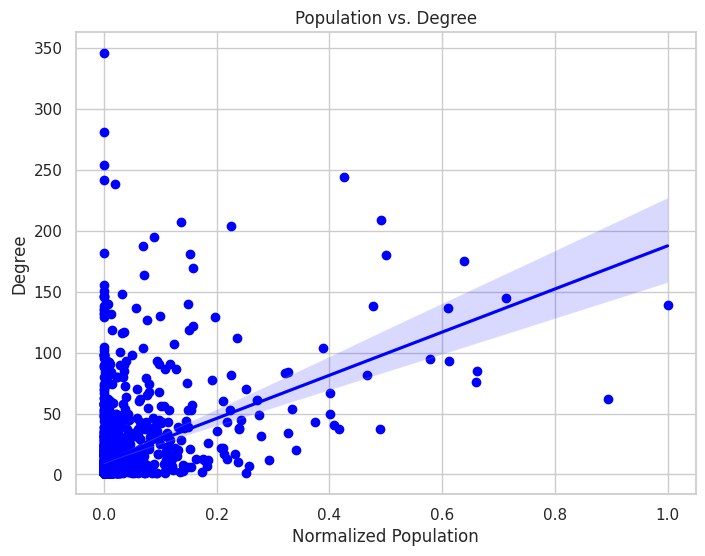

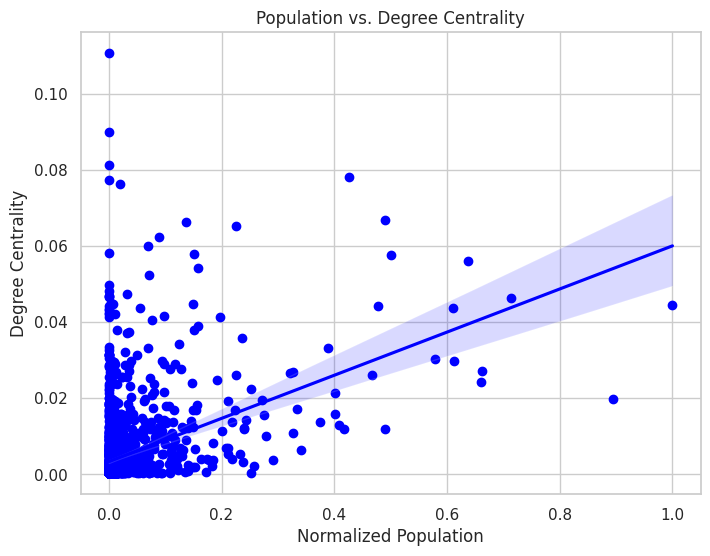

"\n# Scatter plot for population vs. closeness centrality\nplt.figure(figsize=(8, 6))\nplt.scatter(filtered_population_values, filtered_closeness_values, color='green', label='Closeness Centrality')\nsns.regplot(x=filtered_population_values, y=filtered_closeness_values, scatter=False, color='green', line_kws={'color': 'green'})\nplt.xlabel('Normalized Population')\nplt.ylabel('Closeness Centrality')\nplt.title('Population vs. Closeness Centrality')\nplt.show()\n\n# Scatter plot for population vs. betweenness centrality\nplt.figure(figsize=(8, 6))\nplt.scatter(filtered_population_values, filtered_betweenness_values, color='red', label='Betweenness Centrality')\nsns.regplot(x=filtered_population_values, y=filtered_betweenness_values, scatter=False, color='red', line_kws={'color': 'red'})\nplt.xlabel('Normalized Population')\nplt.ylabel('Betweenness Centrality')\nplt.title('Population vs. Betweenness Centrality')\nplt.show()\n\n# Scatter plot for population vs. eigenvector centrality\nplt

In [41]:
sns.set(style="whitegrid")

# Scatter plot for population vs. degree
plt.figure(figsize=(8, 6))
plt.scatter(filtered_population_values, filtered_degree_values2, color='blue', label='Degree')
sns.regplot(x=filtered_population_values, y=filtered_degree_values2, scatter=False, color='blue', line_kws={'color': 'blue'})
plt.xlabel('Normalized Population')
plt.ylabel('Degree')
plt.title('Population vs. Degree')
plt.show()

# Scatter plot for population vs. degree centrality
plt.figure(figsize=(8, 6))
plt.scatter(filtered_population_values, filtered_degree_values, color='blue', label='Degree Centrality')
sns.regplot(x=filtered_population_values, y=filtered_degree_values, scatter=False, color='blue', line_kws={'color': 'blue'})
plt.xlabel('Normalized Population')
plt.ylabel('Degree Centrality')
plt.title('Population vs. Degree Centrality')
plt.show()

Correlation between population and sum of edge weights: 0.45509187816475544


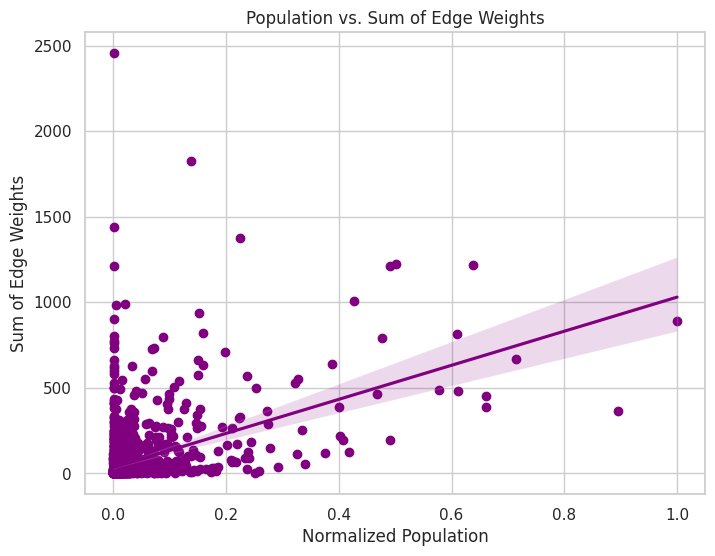

In [44]:
# Filter out nodes where population or edge weight is NaN or infinite
valid_nodes = [
    node for node in nodes_with_population
    if not np.isnan(normalized_population_dict[node]) and np.isfinite(normalized_population_dict[node])
]

# Create a population list for the nodes with population data
filtered_population_values = [normalized_population_dict[node] for node in valid_nodes]

# Get edge weights for the graph (assuming the graph has 'weight' attribute on edges)
edge_weights = {}
for node in valid_nodes:
    total_edge_weight = 0

    # Sum the weights of the edges connected to the node
    for neighbor in G.neighbors(node):
        if 'weight' in G[node][neighbor]:  # Check if weight attribute exists
            total_edge_weight += G[node][neighbor]['weight']

    # Store the total weight for the node
    edge_weights[node] = total_edge_weight

# List of edge weights corresponding to valid nodes
filtered_edge_weights = [edge_weights[node] for node in valid_nodes]

# Ensure no NaN or infinite values in edge weights and population data
filtered_population_values = [pop for pop, weight in zip(filtered_population_values, filtered_edge_weights) if not np.isnan(weight) and np.isfinite(weight)]
filtered_edge_weights = [weight for weight in filtered_edge_weights if not np.isnan(weight) and np.isfinite(weight)]

# Calculate Pearson correlation between population and edge weights
edge_weight_corr, _ = pearsonr(filtered_population_values, filtered_edge_weights)

print(f"Correlation between population and sum of edge weights: {edge_weight_corr}")

# Scatter plot for population vs. edge weights
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
plt.scatter(filtered_population_values, filtered_edge_weights, color='purple', label='Edge Weights')
sns.regplot(x=filtered_population_values, y=filtered_edge_weights, scatter=False, color='purple', line_kws={'color': 'purple'})
plt.xlabel('Normalized Population')
plt.ylabel('Sum of Edge Weights')
plt.title('Population vs. Sum of Edge Weights')
plt.show()